In [1]:
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy import interp
import matplotlib.pyplot as plt
import dataset_utils
import os

In [2]:
def plot_roc(clf, genes, title='Receiver Operating Characteristic'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in range(5):
        train, test = train_sets[i], test_sets[i]
        X, y = train[genes], train['responses'].astype(int)
        X_test, y_test = test[genes], test['responses'].astype(int)

        probas_ = clf.fit(X, y).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    return dataset_utils.plot_roc(tprs, aucs, title)

def plot_ensemble(clf, top_gene_sets, title='Ensemble ROC'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in range(5):
        train, test = train_sets[i], test_sets[i]
        
        probas_ = np.array([0 for _ in range(len(test))])
        for gene_set in top_gene_sets:
            genes = dataset_utils.get_genes(gene_set + ".txt")
            X, y = train[genes], train['responses'].astype(int)
            X_test, y_test = test[genes], test['responses'].astype(int)
            p = clf.fit(X, y).predict_proba(X_test)[:, 1] / float(len(top_gene_sets))
            probas_ = probas_ + p

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
    return dataset_utils.plot_roc(tprs, aucs, title)

In [3]:
train_sets, test_sets = dataset_utils.kfold_train_test_sets('../t_rnaseq_scaled_symbols.csv')
pathways = sorted(os.listdir('gene_sets'))

## Random Forest Metrics

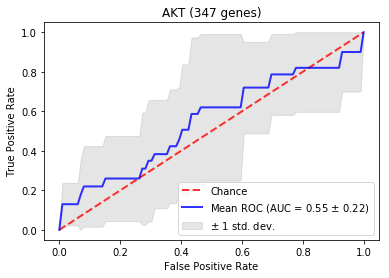

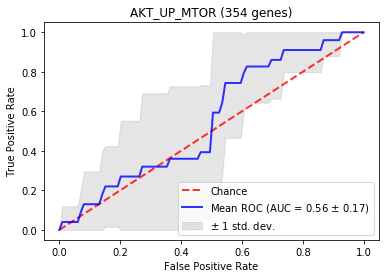

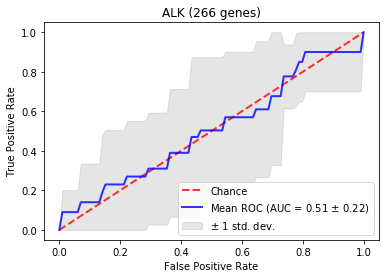

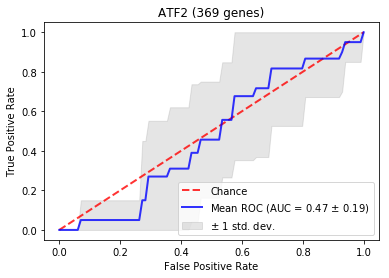

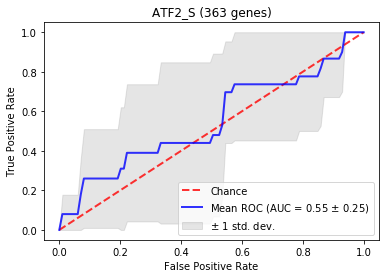

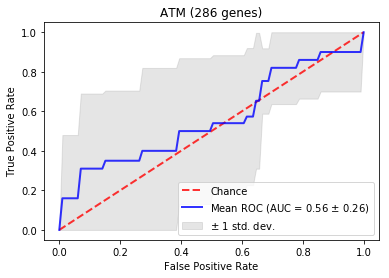

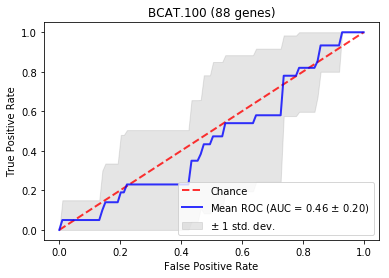

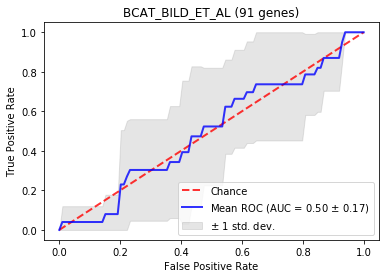

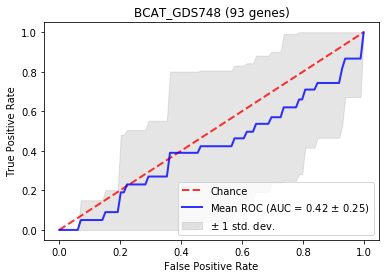

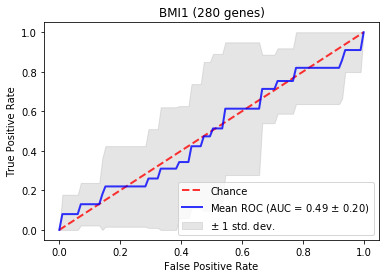

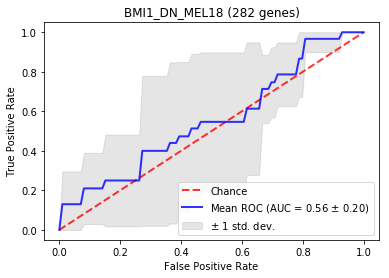

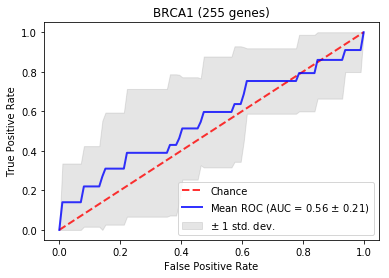

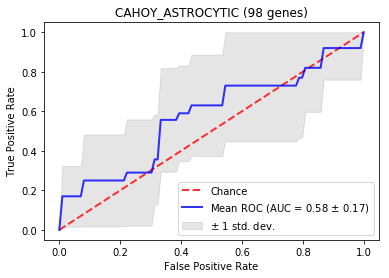

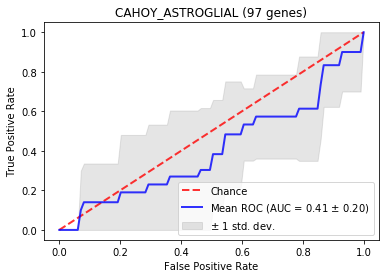

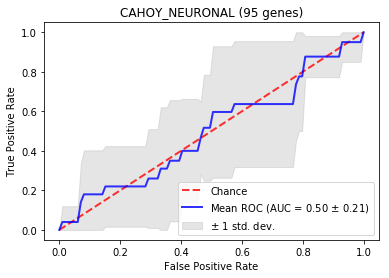

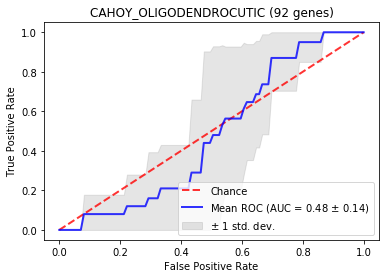

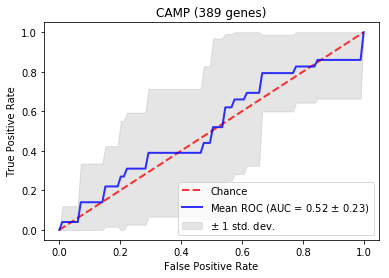

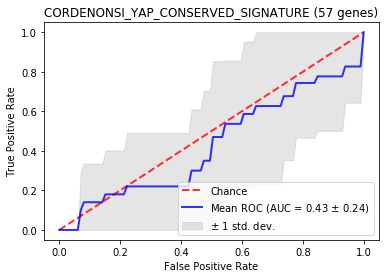

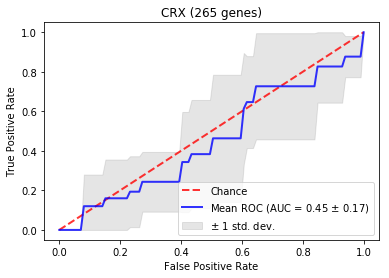

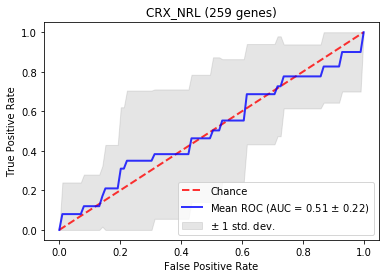

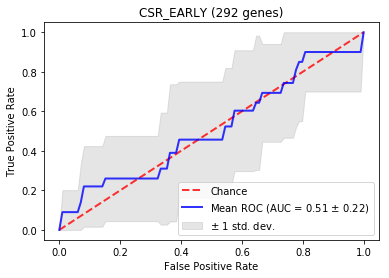

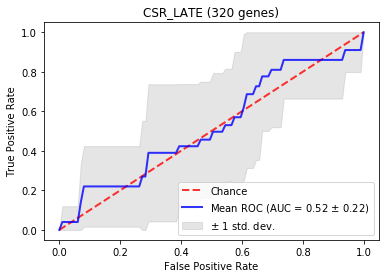

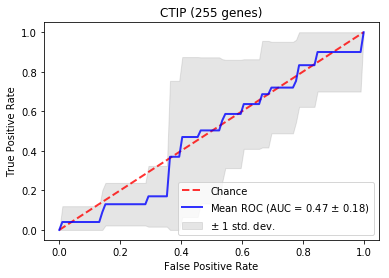

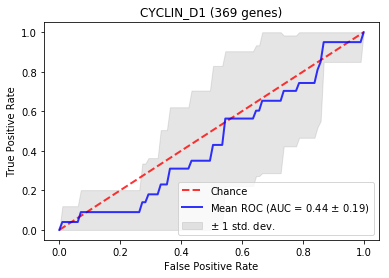

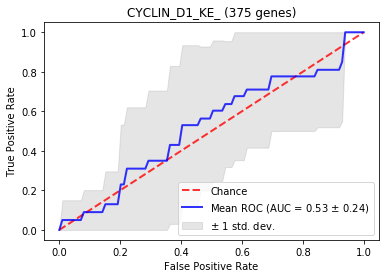

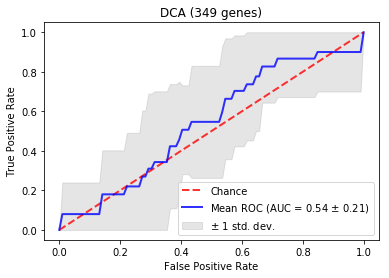

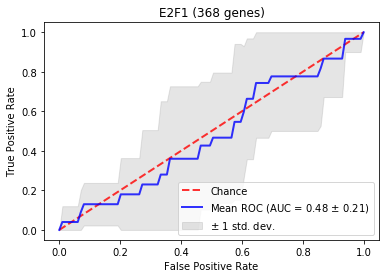

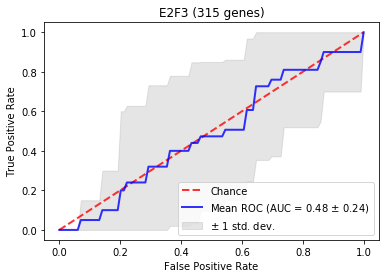

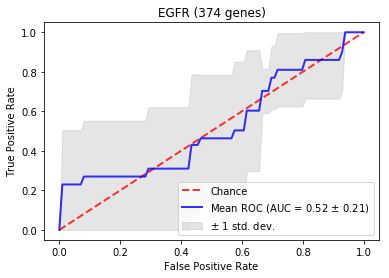

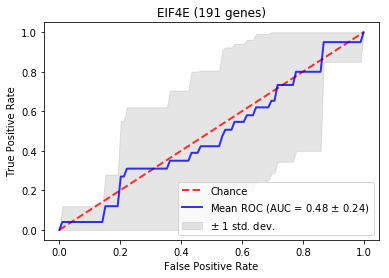

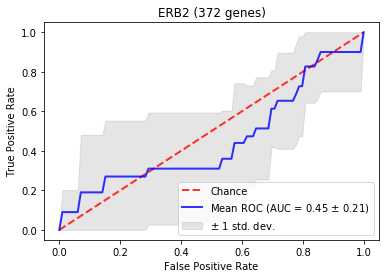

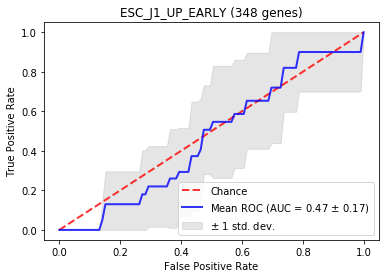

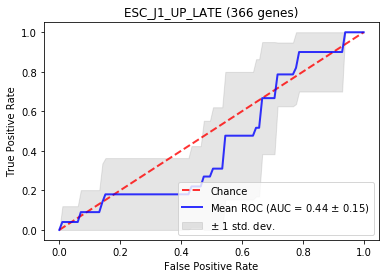

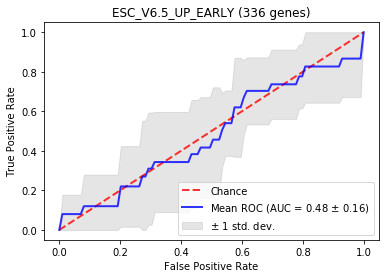

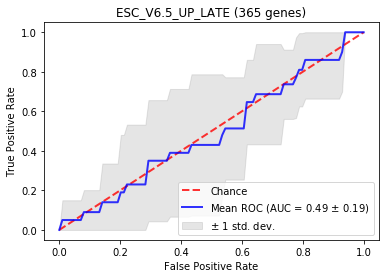

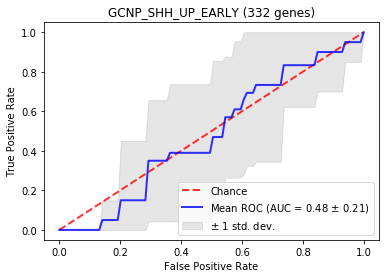

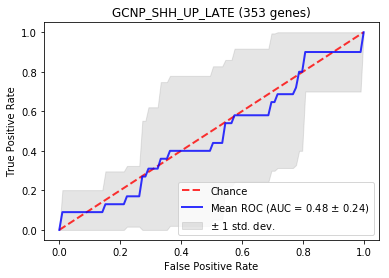

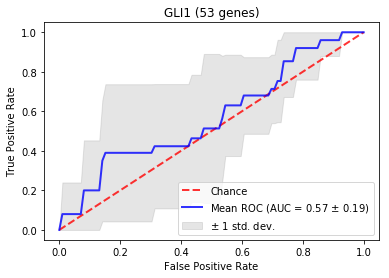

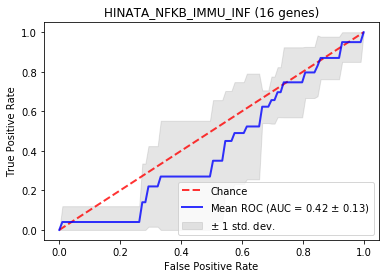

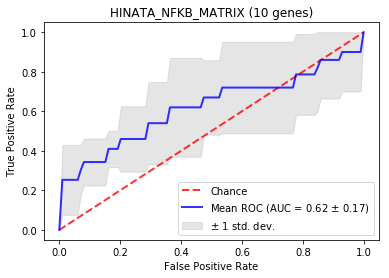

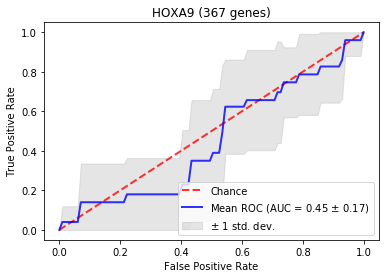

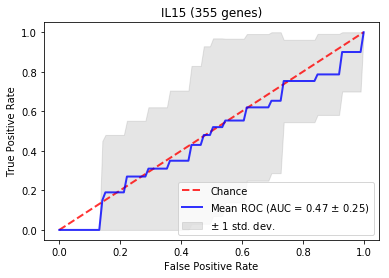

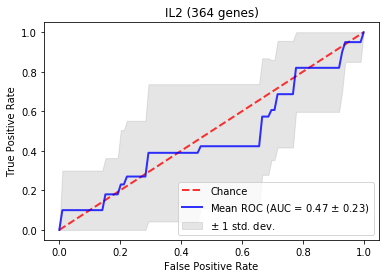

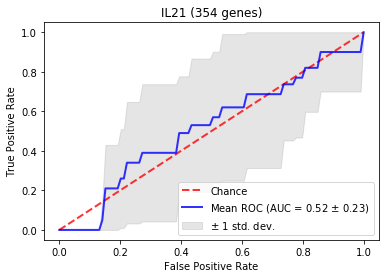

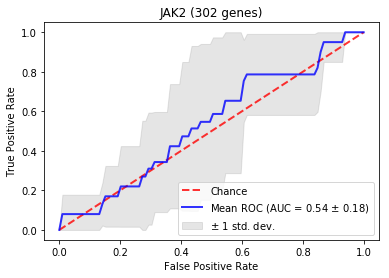

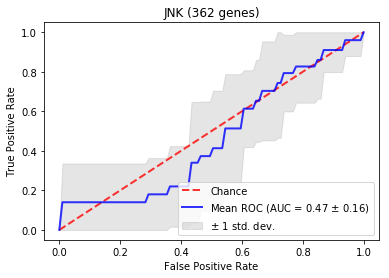

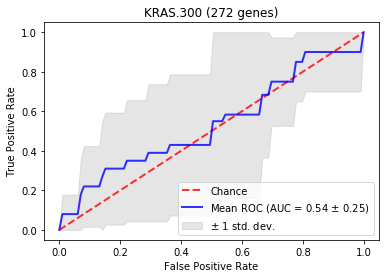

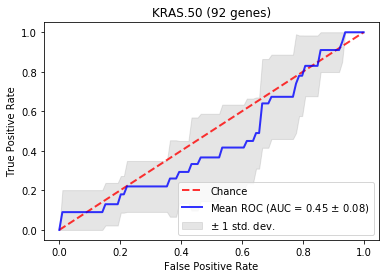

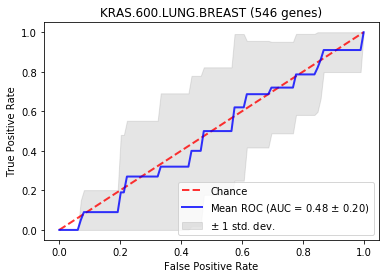

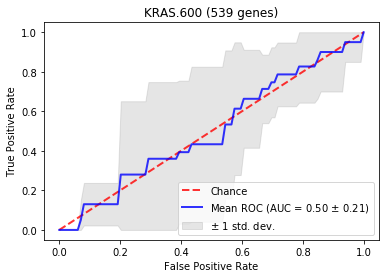

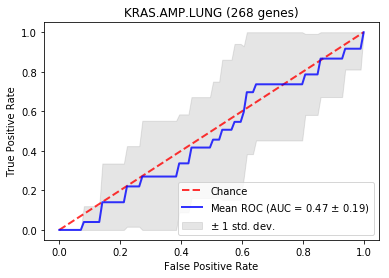

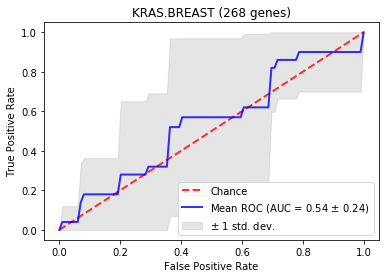

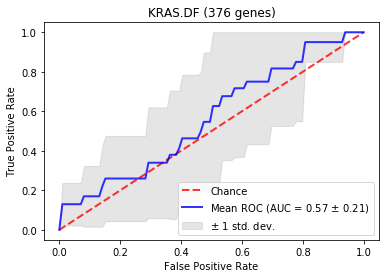

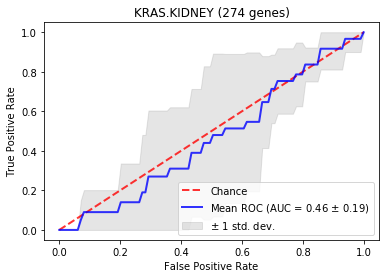

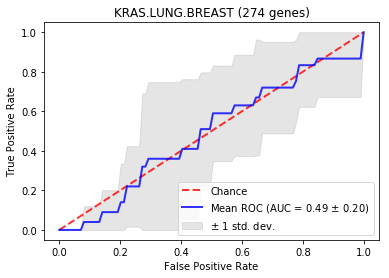

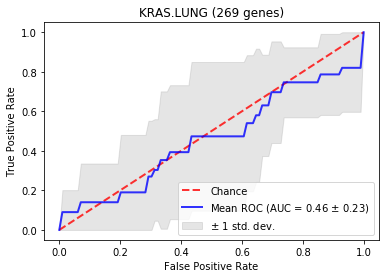

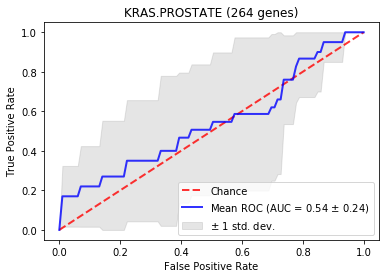

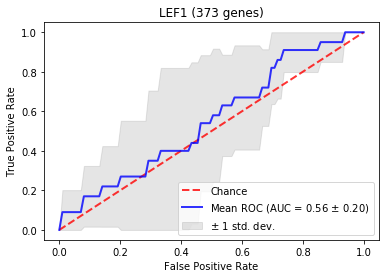

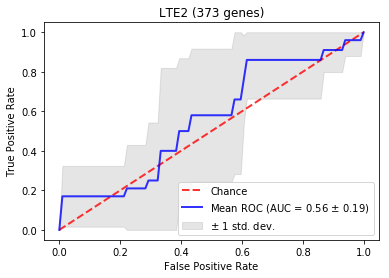

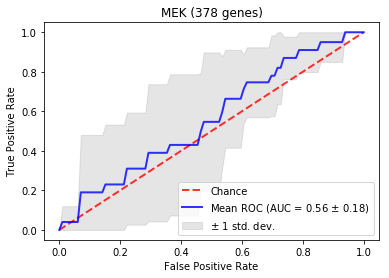

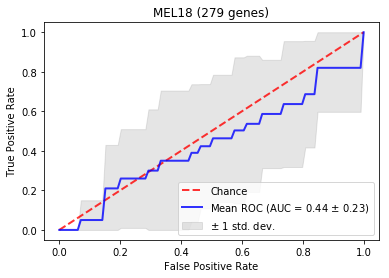

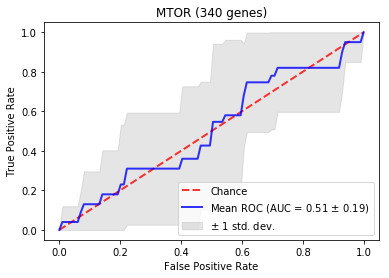

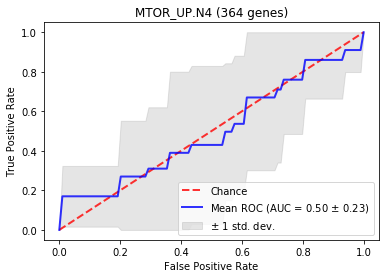

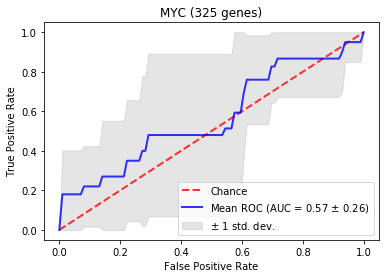

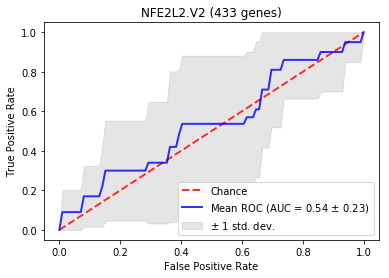

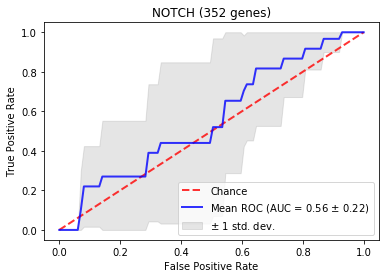

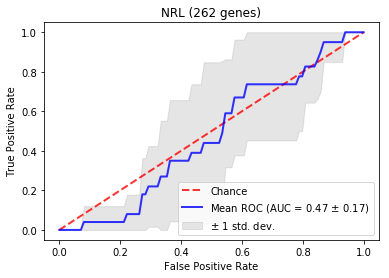

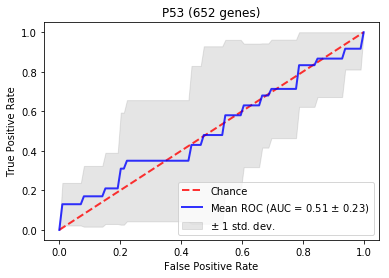

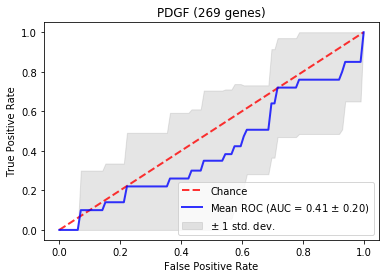

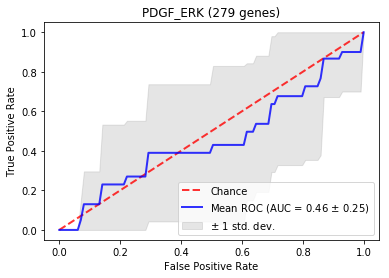

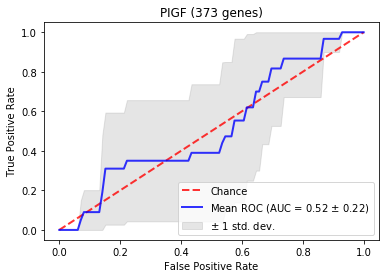

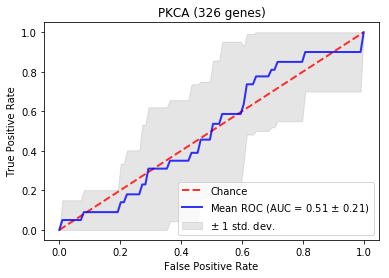

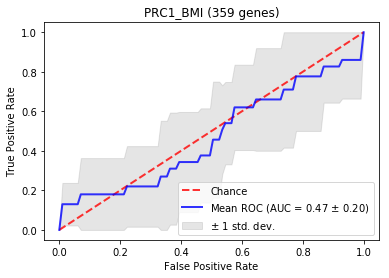

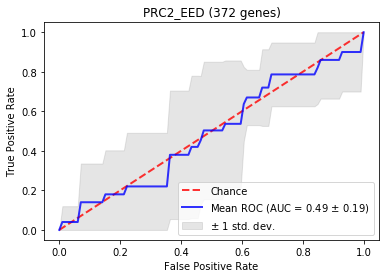

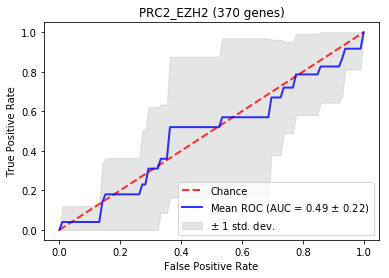

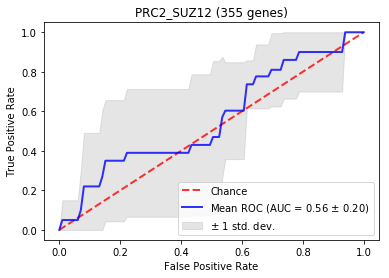

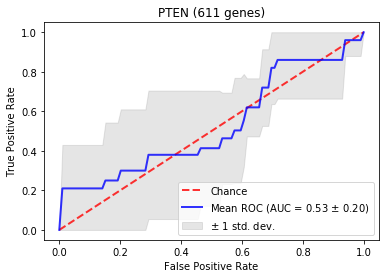

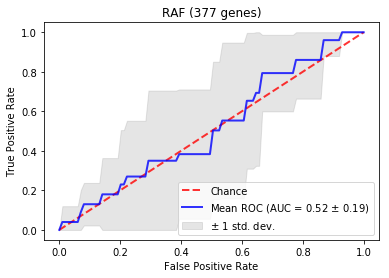

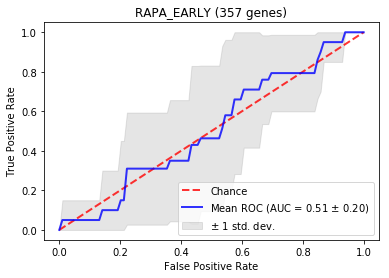

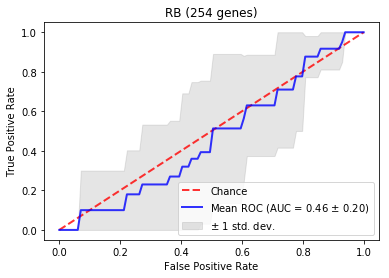

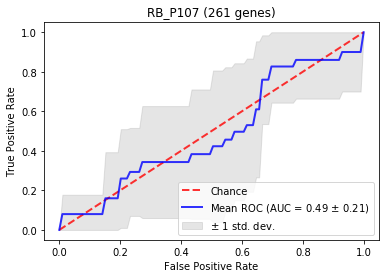

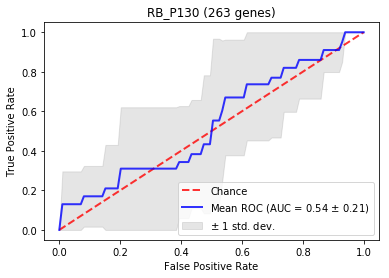

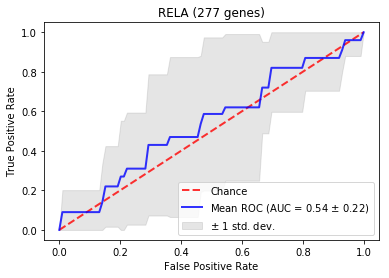

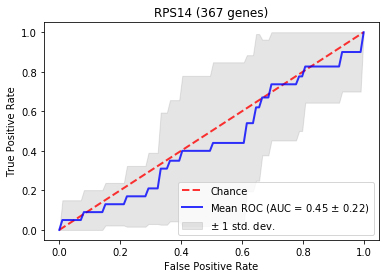

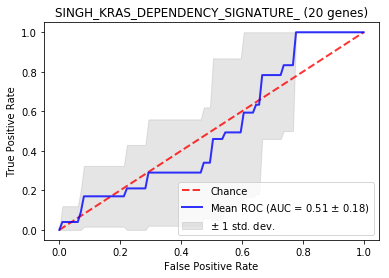

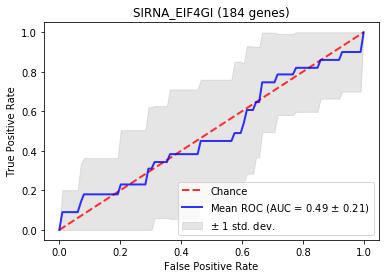

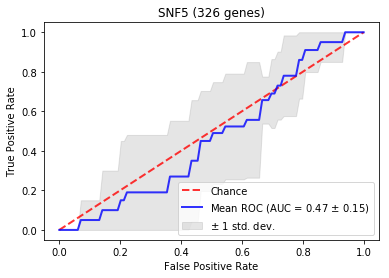

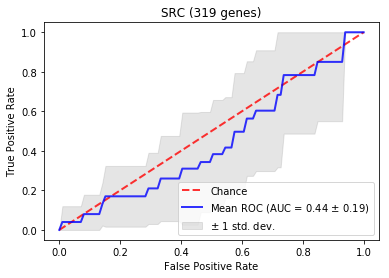

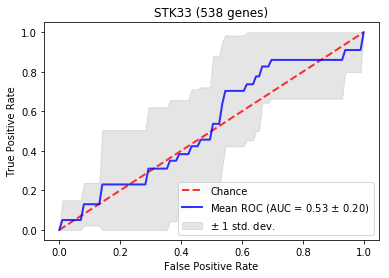

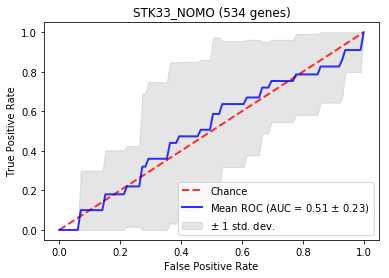

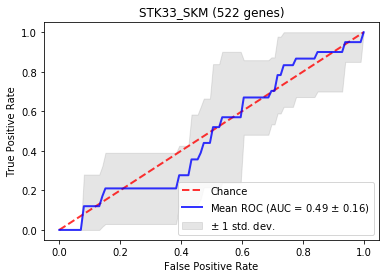

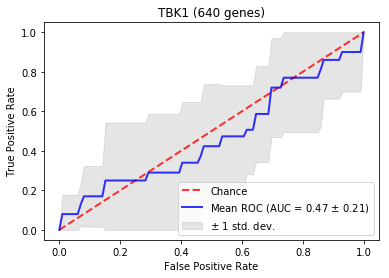

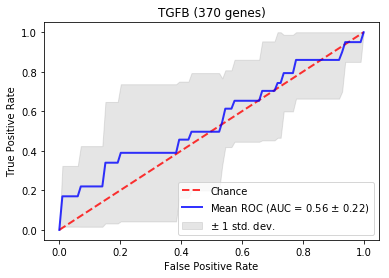

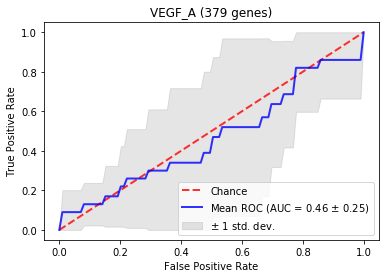

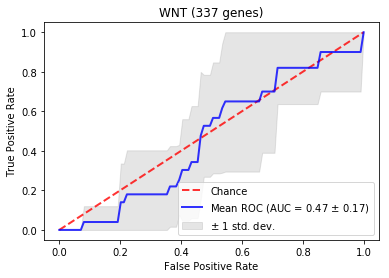

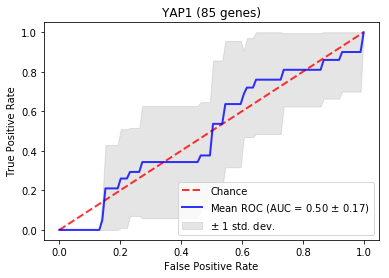

In [4]:
rf_perf = []
for p in pathways:
    clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=7)
    genes = dataset_utils.get_genes(p)
    name = "{} ({} genes)".format('.'.join(p.split('.')[:-1]), len(genes))
    mean_auc = plot_roc(clf, genes, name)
    rf_perf.append((name, mean_auc))

In [5]:
# get top 10 gene sets (by AUROC)
rf_perf.sort(key=lambda x: x[1], reverse=True)
for i in range(10):
    print("{}\t{}".format(rf_perf[i][1], rf_perf[i][0]))

0.62016835016835	HINATA_NFKB_MATRIX (10 genes)
0.5765993265993266	CAHOY_ASTROCYTIC (98 genes)
0.5732659932659933	GLI1 (53 genes)
0.569057239057239	MYC (325 genes)
0.5659259259259259	KRAS.DF (376 genes)
0.5622895622895623	ATM (286 genes)
0.5620202020202021	NOTCH (352 genes)
0.5619191919191919	MEK (378 genes)
0.5603703703703704	PRC2_SUZ12 (355 genes)
0.5598989898989899	LTE2 (373 genes)


# Metrics for SVM 

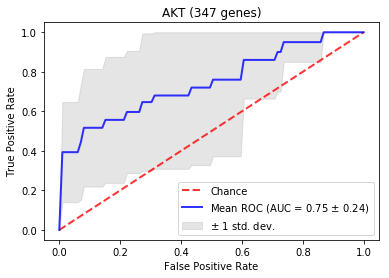

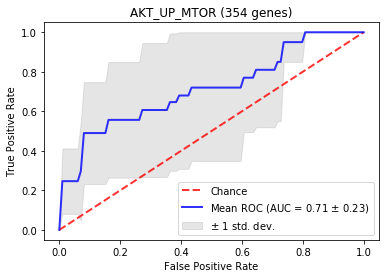

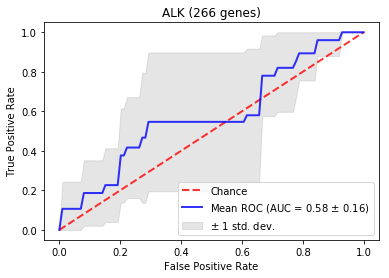

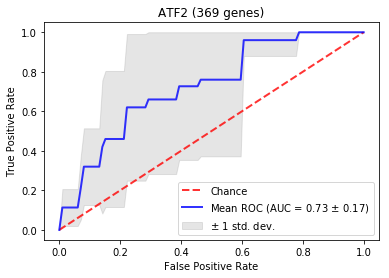

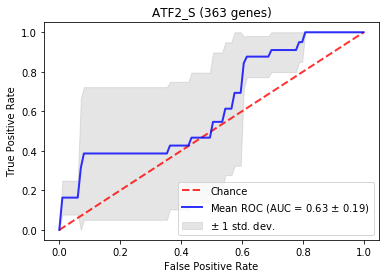

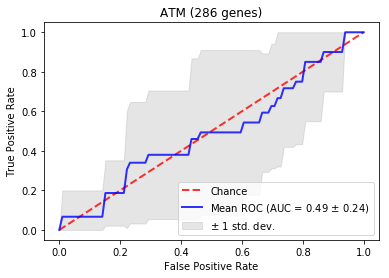

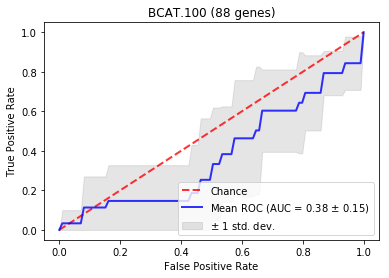

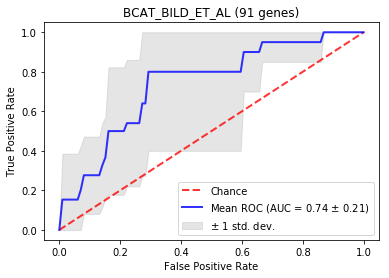

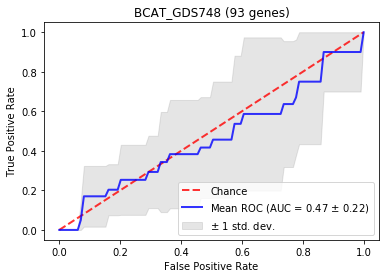

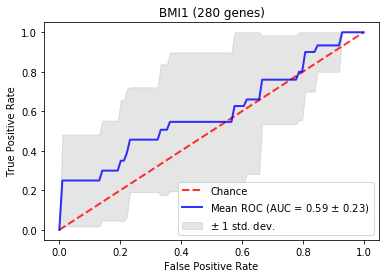

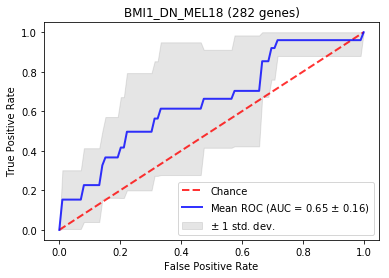

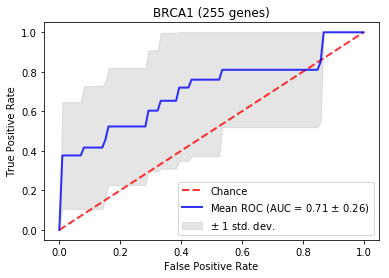

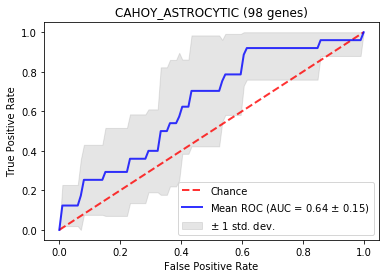

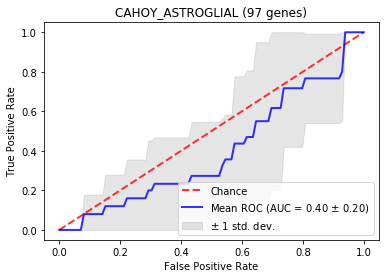

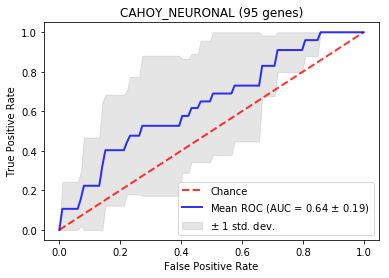

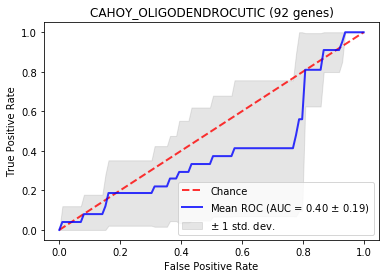

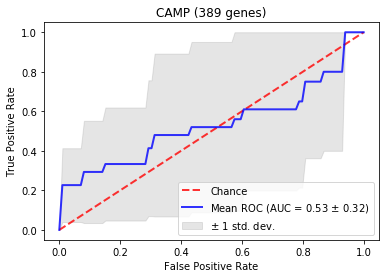

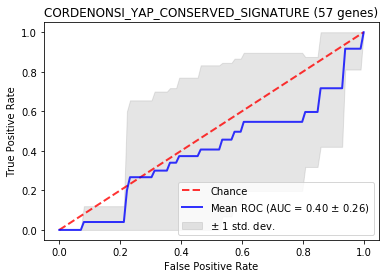

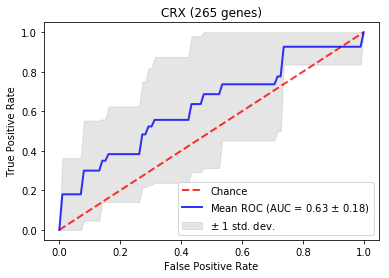

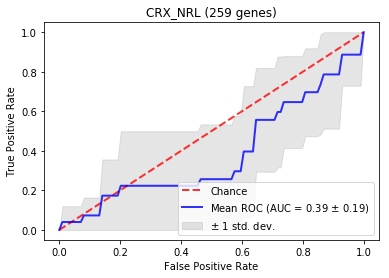

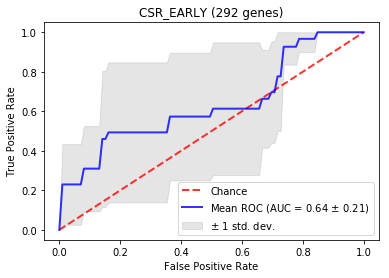

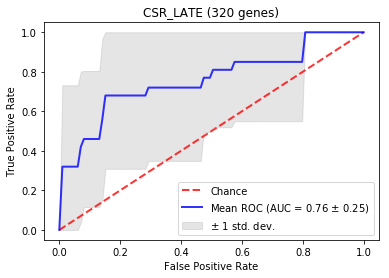

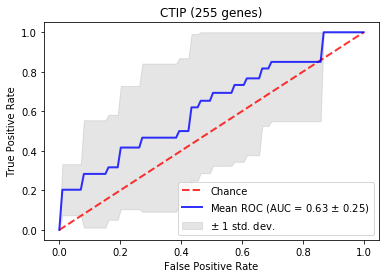

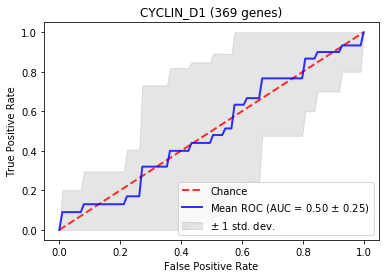

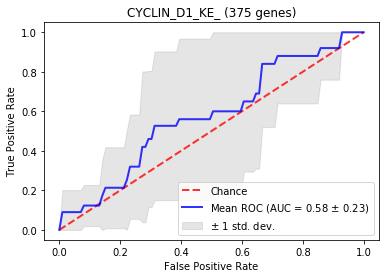

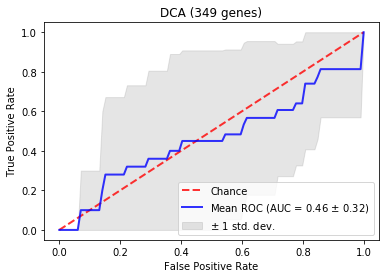

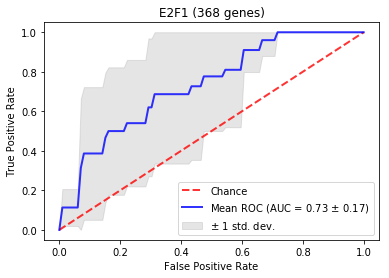

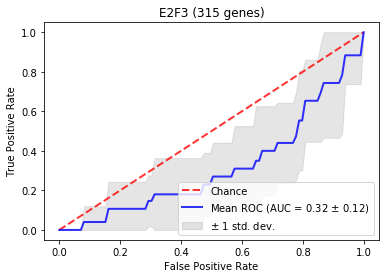

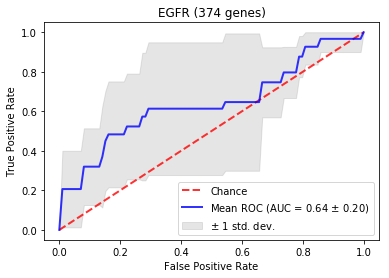

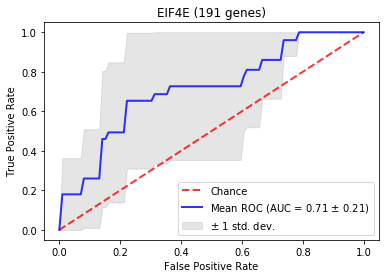

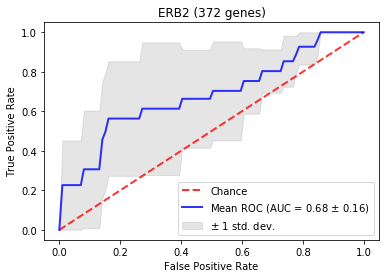

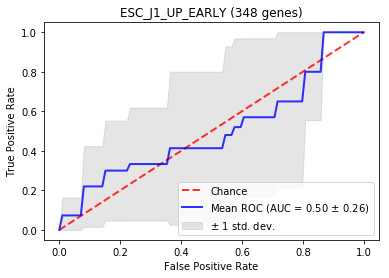

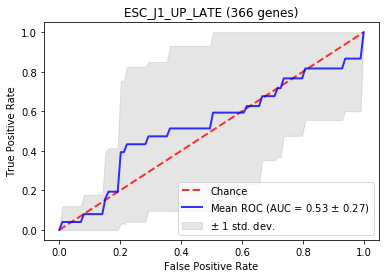

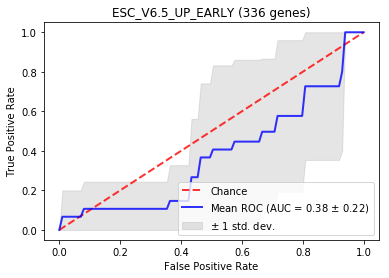

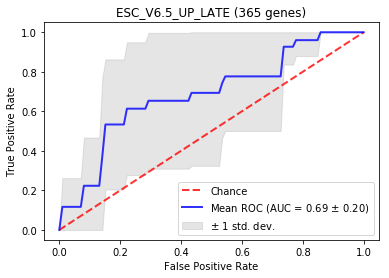

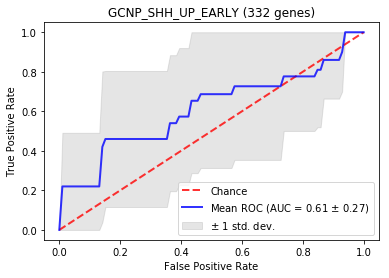

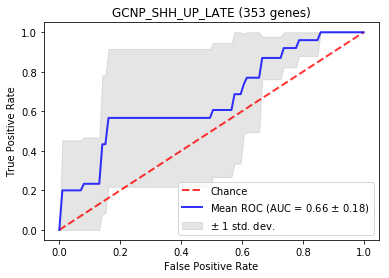

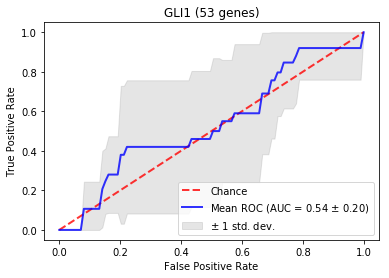

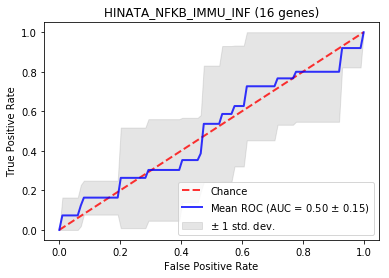

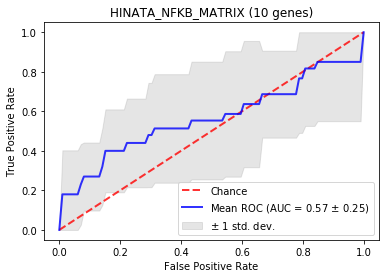

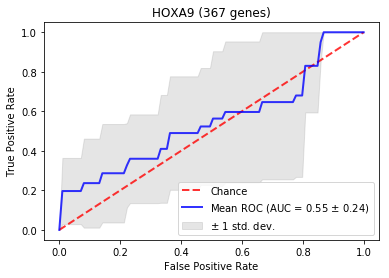

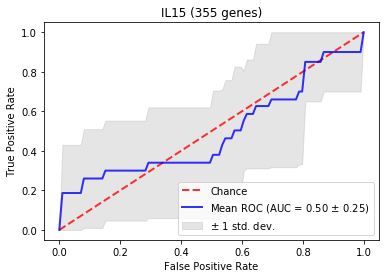

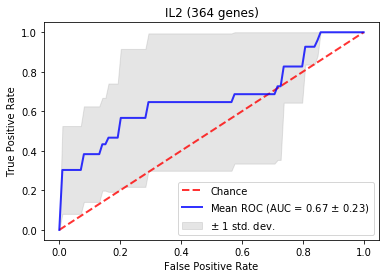

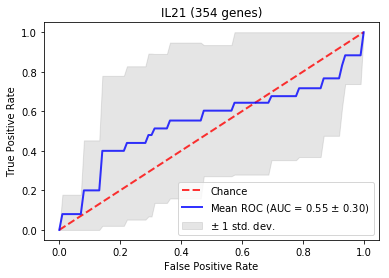

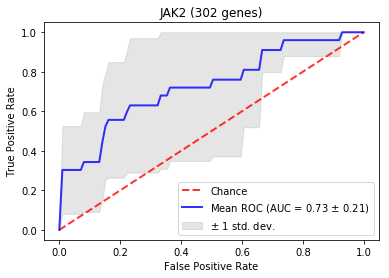

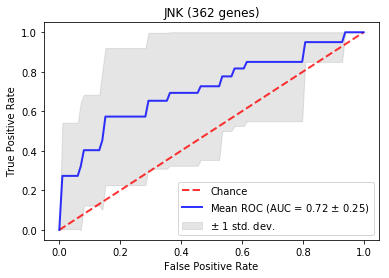

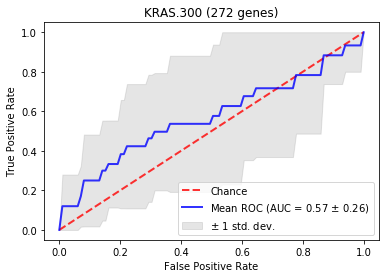

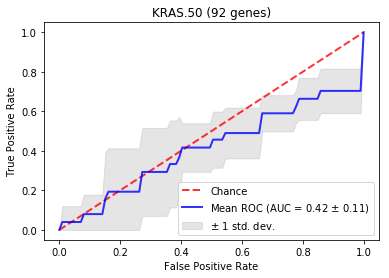

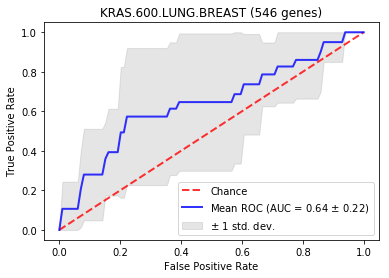

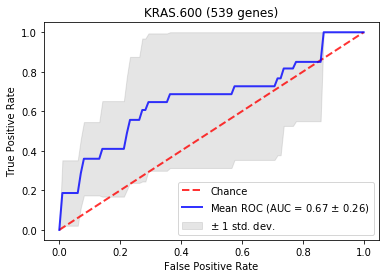

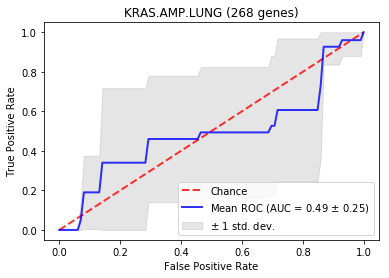

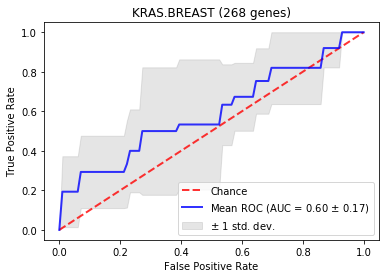

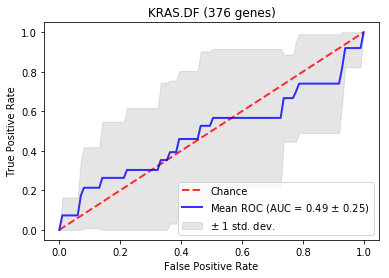

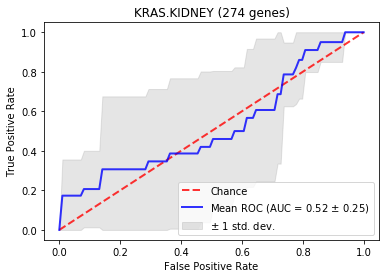

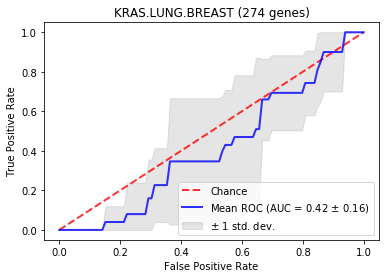

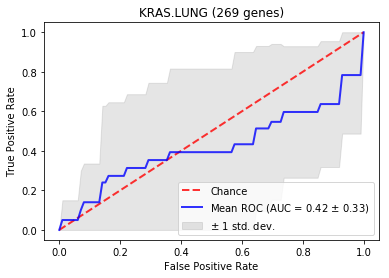

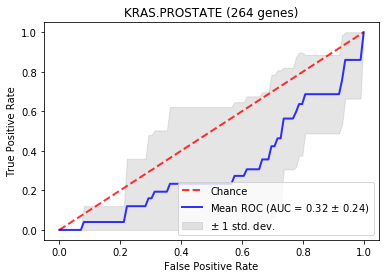

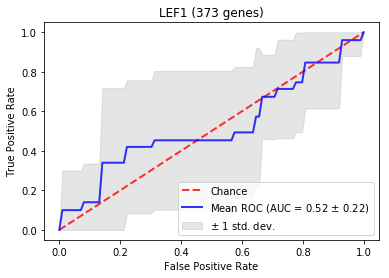

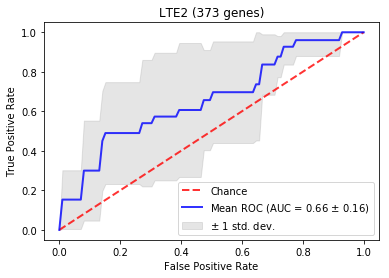

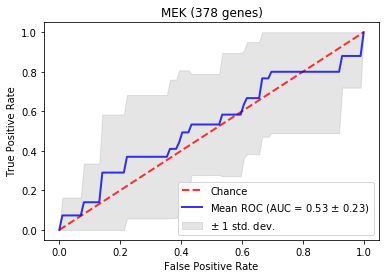

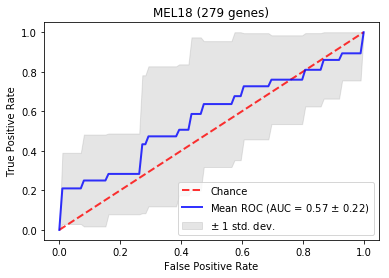

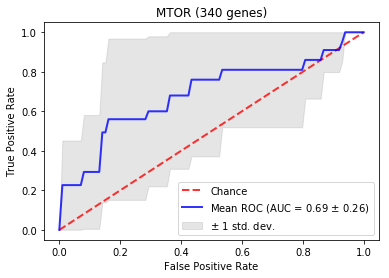

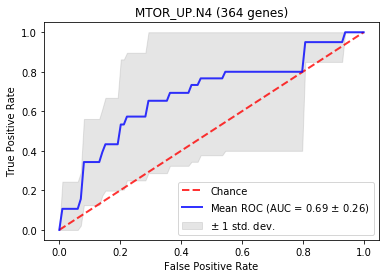

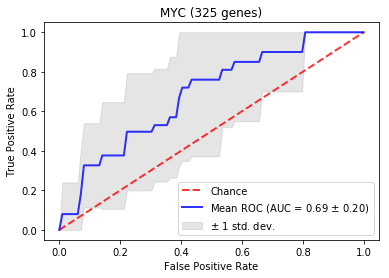

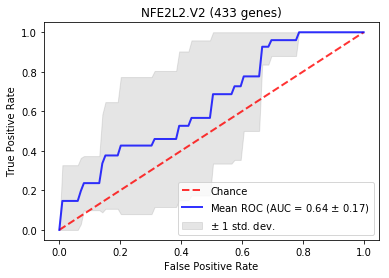

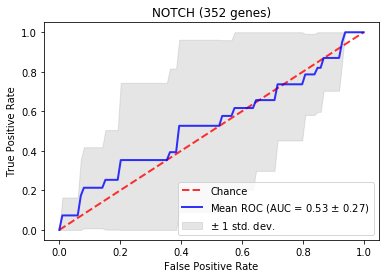

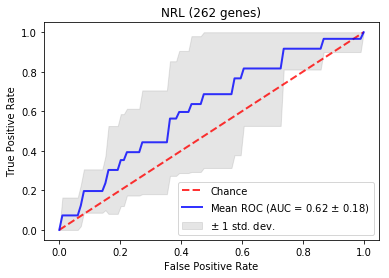

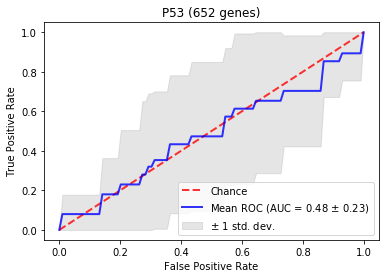

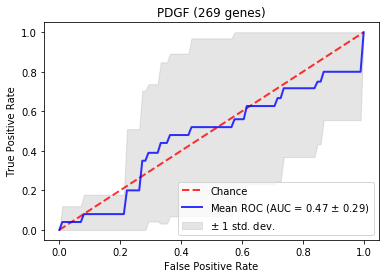

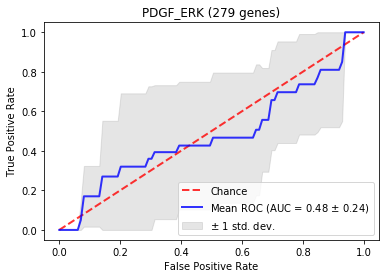

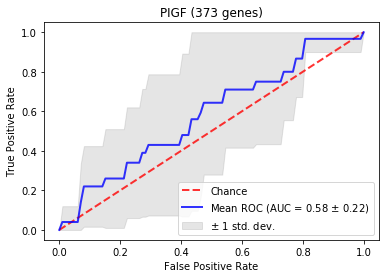

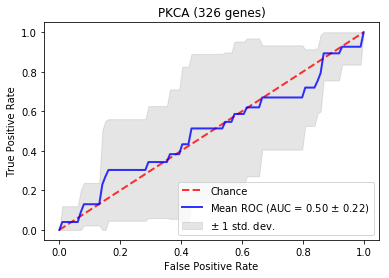

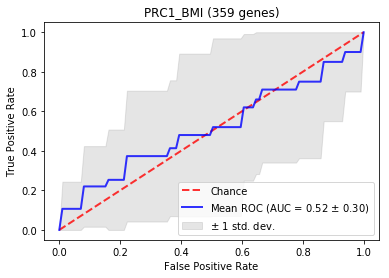

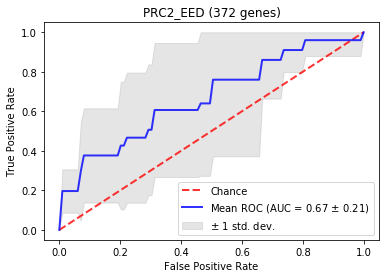

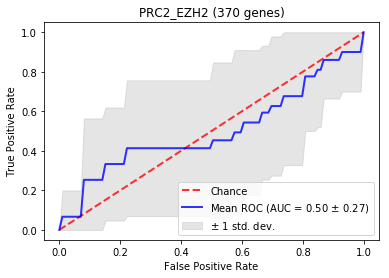

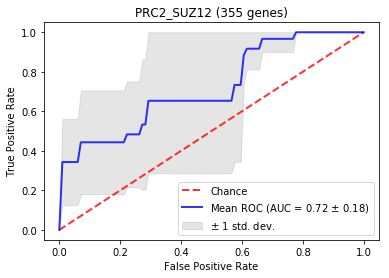

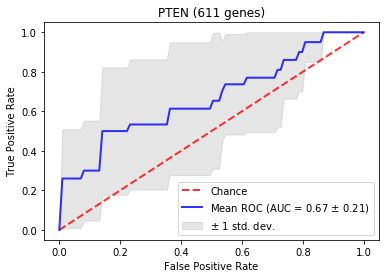

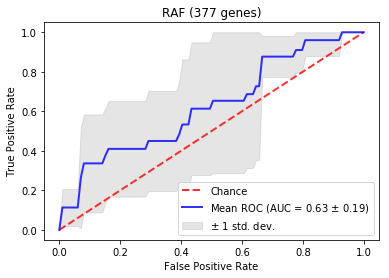

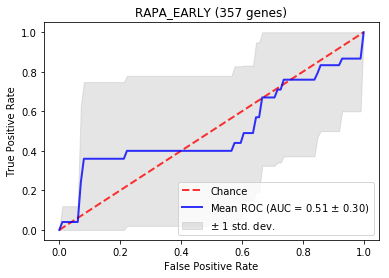

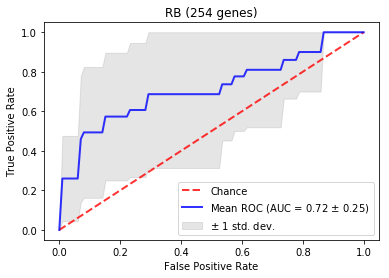

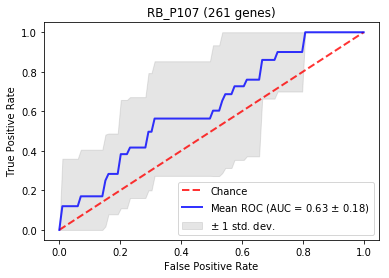

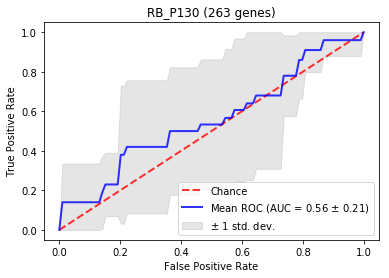

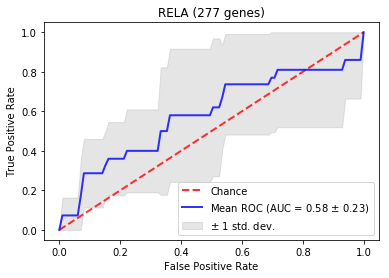

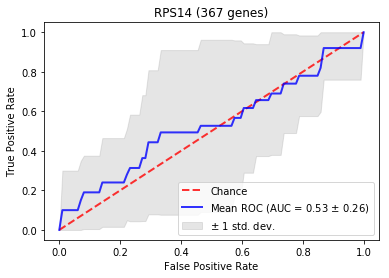

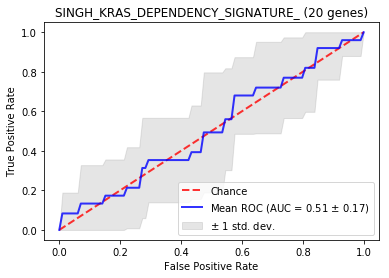

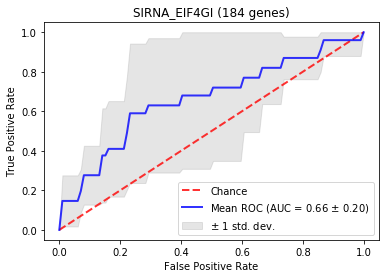

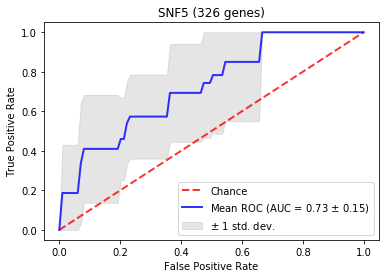

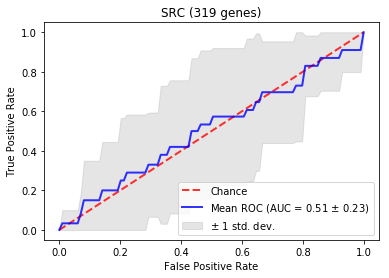

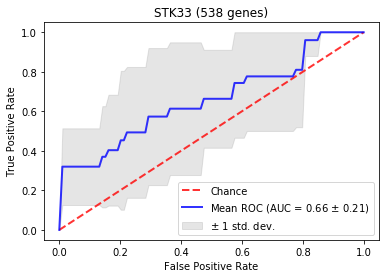

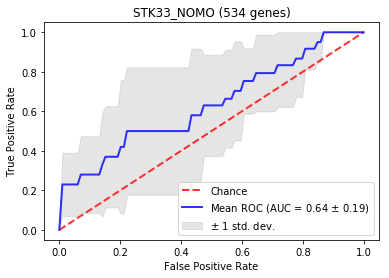

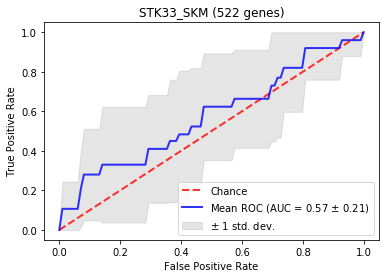

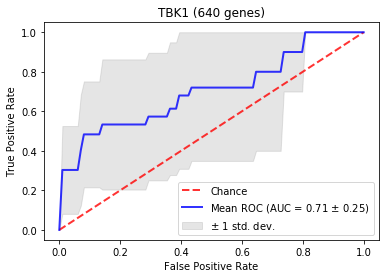

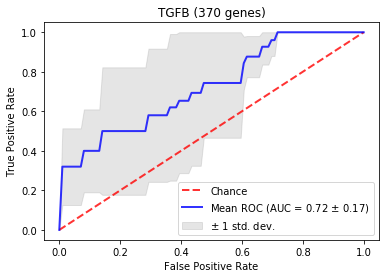

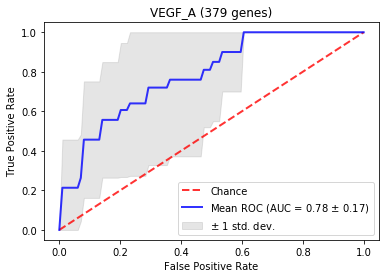

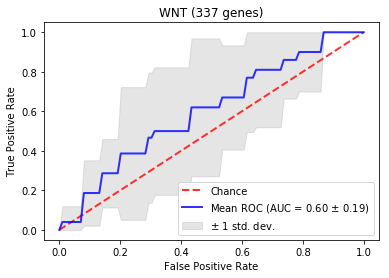

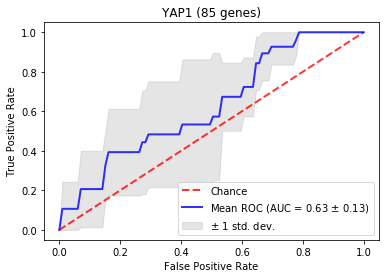

In [6]:
svm_perf = []
for p in pathways:
    clf = SVC(gamma='auto', probability=True)
    genes = dataset_utils.get_genes(p)
    name = "{} ({} genes)".format('.'.join(p.split('.')[:-1]), len(genes))
    mean_auc = plot_roc(clf, genes, name)
    svm_perf.append((name, mean_auc))

In [7]:
# get top 10 gene sets (by AUROC)
svm_perf.sort(key=lambda x: x[1], reverse=True)
for i in range(10):
    print("{}\t{}".format(svm_perf[i][1], svm_perf[i][0]))

0.7824579124579124	VEGF_A (379 genes)
0.7592929292929292	CSR_LATE (320 genes)
0.7454208754208754	AKT (347 genes)
0.738956228956229	BCAT_BILD_ET_AL (91 genes)
0.7312121212121212	E2F1 (368 genes)
0.728047138047138	JAK2 (302 genes)
0.727070707070707	SNF5 (326 genes)
0.7262626262626262	ATF2 (369 genes)
0.7225925925925925	TGFB (370 genes)
0.7200673400673401	PRC2_SUZ12 (355 genes)


In [8]:
# get union of top K gene_sets
K = 3
top_union = dataset_utils.get_gene_sets_union(svm_perf, K)
print("Trastuzumab treatment: {} total genes in top {} gene sets".format(len(top_union), K))

Trastuzumab treatment: 1005 total genes in top 3 gene sets


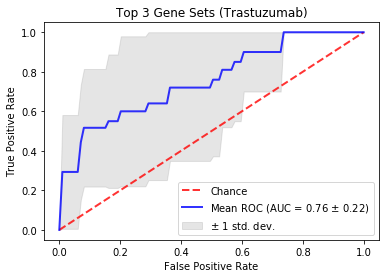

0.7552188552188552

In [9]:
# SVM on only genes from top gene sets
top_genes = list(top_union)
clf = SVC(gamma='auto', probability=True)
plot_roc(clf, top_genes, "Top {} Gene Sets (Trastuzumab)".format(K))

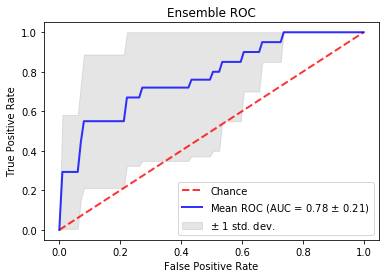

0.7777104377104377

In [10]:
# Ensemble with top gene sets
K = 3
top_gene_sets = [svm_perf[i][0].split()[0] for i in range(K)]
plot_ensemble(SVC(gamma='auto', probability=True), top_gene_sets)